# Second models
We are now trying to add the categorical features. There is no ordinal feature in the dataset, we will the use the One-Hot Encoding method to deal with it. Here is the basis on how the data are transformed : 
- Deleting the columns ['CurrencyCode', 'CountryCode'] because it only has one value and won't have influence on the target. 
- Set the index to the id of the TransactionId column
- Adding some data related to the date. We created the columns from the TransactionStartTime : the day, the hour, the day of the week, and the week of the month. After evaluation of the MI, we considered that the seconds and minutes of the transaction were did not have a lot of influence of the target and will not be considered to not add too much new features. 
- Drop the column datetime because the models don't takes this format
- Create the One-Hot-Encoding on the low cardinality columns : ['ProviderId', 'ProductCategory', 'ChannelId', 'PricingStrategy']
- Transforming the string columns into int

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import datetime as dt
from math import ceil
from Utils import *
pd.set_option('max_colwidth', None)
from EvaluationMetric import *

## 1. With OHE and without TransactionStartTime column

In [ ]:
# data cleaning
#Data loading
def_feature = pd.read_csv("input/Xente_Variable_Definitions.csv")
raw_data = pd.read_csv("input/training.csv")
X_test = pd.read_csv("input/test.csv")
sample_submission = pd.read_csv("input/sample_submission.csv")

#attribut initialization
cols_unique_value = [] #Will be droped
for col in raw_data.columns : 
    if len(raw_data[col].unique()) == 1 :
        cols_unique_value.append(col)
        
medium_cardianlity_cols = ["ProductId"]

#Data transformation
raw_data['TransactionStartTime'] = pd.to_datetime(raw_data['TransactionStartTime'])
X_test['TransactionStartTime'] = pd.to_datetime(X_test['TransactionStartTime'])

#Data cleaning
data = raw_data.copy()
data = data.dropna(axis=0) #Drop observations/rows with missing values
X_test=X_test.dropna(axis=0)
data.drop(cols_unique_value, axis=1, inplace=True)
X_test.drop(cols_unique_value, axis=1, inplace=True)

#Prepare index for the submission
index_val = list(X_test.TransactionId.values.tolist())

#Set the df index to the Transction Id
data = transactioId_to_index(data)
X_test = transactioId_to_index(X_test)

#Adding data
data = adding_date_col(data, 'TransactionStartTime')
X_test = adding_date_col(X_test, 'TransactionStartTime')


# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in data.columns if data[cname].nunique() < 15 and 
                        data[cname].dtype == "object"]
low_cardinality_cols.append('PricingStrategy')

#transform columns BatchId_54 to number

l_col_str = ["BatchId", "AccountId", "SubscriptionId", "CustomerId", "ProviderId", "ProductId", "ChannelId"]
for col in l_col_str:
    data[['dc', 'new_col']] = data[col].str.split("_", expand = True)
    data.drop(['dc',col], inplace=True, axis=1)
    data.rename(columns={"new_col": col}, inplace=True)
    data[col] = data[col].astype('int')
    X_test[['dc', 'new_col']] = X_test[col].str.split("_", expand = True)
    X_test.drop(['dc',col], inplace=True, axis=1)
    X_test.rename(columns={"new_col": col}, inplace=True)
    X_test[col] = X_test[col].astype('int')
data['PricingStrategy'] = data['PricingStrategy'].astype('int')
X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('int')
data['Value'] = data['Value'].astype('float')
X_test['Value'] = X_test['Value'].astype('float')

X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('str')
data['PricingStrategy'] = data['PricingStrategy'].astype('str')

#Data splitting
y = data.FraudResult #The target label
X = data.copy()
X.drop(['FraudResult'], axis=1, inplace=True) #Only the features data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

#Other data
#Information on columns on raw_data
## P-e transformer ca en une fonction ? 
info = pd.DataFrame(data = raw_data.dtypes)
info.reset_index(inplace=True)
info.rename({'index':'Column Name', 0: 'Dtype'}, axis=1, inplace=True)
describe = def_feature.copy()
describe = describe.merge(info)
unique_val = []
for col in list(describe["Column Name"]) : 
    unique_val.append(len(raw_data[col].unique()))
describe["unique"]=unique_val
describe = added_column(describe)
cat_cols = [col for col in train_X.columns if train_X[col].dtype == "object"]#liste of obejct columns
cat_cols.append("PricingStrategy")#pcq mm si c'est un chiffre il faut le considérer comme une catégorie

#print(describe)


#low_cardinality_cols=["ProviderId", "ProductCategory", "ChannelId", "PricingStrategy"] 
#train_X[low_cardinality_cols] = train_X[low_cardinality_cols].astype(str) 
#val_X[low_cardinality_cols] = val_X[low_cardinality_cols].astype(str) 

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X[low_cardinality_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[low_cardinality_cols]))
# One-hot encoding removed index; put it back
OH_cols_train.index = train_X.index
OH_cols_valid.index = val_X.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
#print(f'Col avant : {train_X.columns}')
num_X_train = train_X.drop(low_cardinality_cols, axis=1)
num_X_valid = val_X.drop(low_cardinality_cols, axis=1)
num_X_test = X_test.drop(low_cardinality_cols, axis=1)
#print(f'col num : {num_X_train.columns}')

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
#print(f'col apres concat : {OH_X_train.columns}')
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

# Problème de string
OH_X_train.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_valid.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_test.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)
OH_X_test.columns = OH_X_test.columns.astype(str)

train_X = OH_X_train
val_X = OH_X_valid

In [ ]:
train_X.head()

,Amount,Value,Day,Hour,week_day,weeks,BatchId,AccountId,SubscriptionId,CustomerId,...,13,14,15,16,17,18,19,20,21,22
TransactionId,,,,,,,,,,,,,,,,,,,,,
82059,2500.0,2500.0,28,10,4,4,48408,2946,3991,3371,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
115282,1000.0,1000.0,9,7,2,2,5122,4468,3787,4928,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
36103,2000.0,2000.0,15,15,5,2,117608,3750,3024,4193,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5655,-1000.0,1000.0,24,8,5,4,75137,4841,3829,4371,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
87110,-5000.0,5000.0,7,6,4,1,84248,4841,3829,2710,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
train_X.columns

Index(['Amount', 'Value', 'Day', 'Hour', 'week_day', 'weeks', 'BatchId',
       'AccountId', 'SubscriptionId', 'CustomerId', 'ProductId', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '19', '20', '21', '22'],
      dtype='object')

## Try on models
### Decision Tree Classifier

In [ ]:
model = DecisionTreeClassifier(random_state=1)
model.fit(train_X, train_y)
model_pred = model.predict(val_X)
model_test = model.predict(OH_X_test)
df = getscoreforcsv(index_val, model_test)
report = listmetrics(val_y, model_pred, "Decision Tree Classifier", "with Categories OHE without DateTime")
report[-2] = 0.59375
report[-1] = 0.590909090
report

done


['Decision Tree Classifier',
 'with Categories OHE without DateTime',
 Timestamp('2023-04-29 17:28:03.706914'),
 0.7307692307692307,
 0.95,
 0.8260869565217392,
 0.024113499507688565,
 0.8329001768467879,
 0.59375,
 0.59090909]

In [ ]:
def graphmetrics(df, rangelist):
    x = rangelist
    y1 = df.Precision.values
    y2 = df.Recall.values
    y3 = df["F1-score"].values
    y4 = df.LogLoss.values
    y5 = df.Mcc.values

    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(x, y1, 'g-o', label = "Precision")
    ax1.plot(x, y2, 'b-o', label = "Recall")
    ax1.plot(x, y3, 'r-o', label = "F1-score")
    ax2.plot(x, y4, 'b-o', label = "LogLoss")
    ax1.plot(x, y5, 'y-o', label = "Mcc")
    plt.legend()


    ax2.set(xlim=(rangelist[0], rangelist[-1]), xticks=np.arange(rangelist[0], rangelist[-1]), ylim=(0.005, 0.04), yticks=np.arange(0.005, 0.04, 0.005), xlabel = "max_leaf_nodes")
    ax2.set_title('Log loss')
    ax1.set(xlim=(rangelist[0], rangelist[-1]), xticks=np.arange(rangelist[0], rangelist[-1]), ylim=(0.5, 1), yticks=np.arange(0.5, 1, 0.05), xlabel = "max_leaf_nodes", ylabel = "metrics")
    ax1.legend()

    plt.title("Metrics Decision Tree")

    plt.legend()
    plt.show()

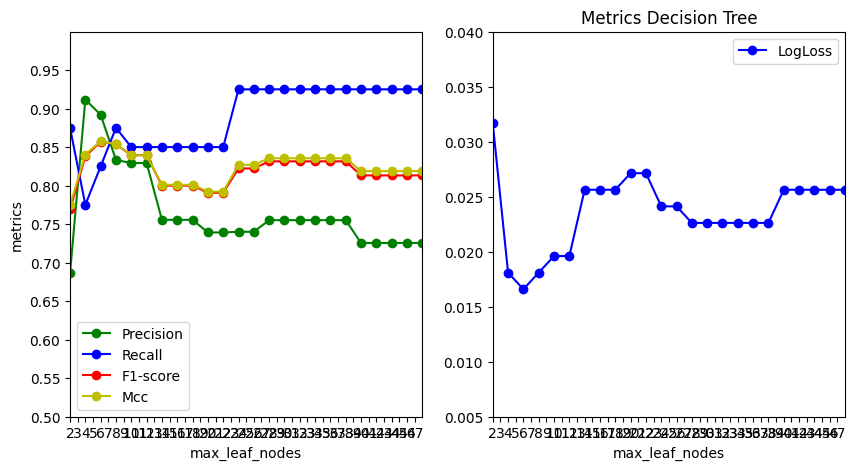

In [ ]:
def test_leaf(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    description = "max_leaf_nodes : "+str(max_leaf_nodes)
    metrics = listmetrics(val_y, preds_val, "Decision Tree Classifier", description)
    return(metrics)


results = []
#for max_leaf_nodes in [3, 4, 5, 6, 7, 8, 9, 10]:
for max_leaf_nodes in np.arange(2, 50, 2, dtype=int):
    my_metrics_tree = test_leaf(max_leaf_nodes, train_X, val_X, train_y, val_y)
    results.append(my_metrics_tree)
df = listmetricsintodf(results)
df.head()

graphmetrics(df, np.arange(2, 50, 2, dtype=int))


In [ ]:
df

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore
0,Decision Tree Classifier,max_leaf_nodes : 2,2023-04-29 17:44:09.536838,0.686275,0.875,0.769231,0.031649,0.774498,NaN,NaN
1,Decision Tree Classifier,max_leaf_nodes : 4,2023-04-29 17:44:09.678339,0.911765,0.775,0.837838,0.018085,0.840364,NaN,NaN
2,Decision Tree Classifier,max_leaf_nodes : 6,2023-04-29 17:44:09.830164,0.891892,0.825,0.857143,0.016578,0.857566,NaN,NaN
3,Decision Tree Classifier,max_leaf_nodes : 8,2023-04-29 17:44:09.981397,0.833333,0.875,0.853659,0.018085,0.853662,NaN,NaN
4,Decision Tree Classifier,max_leaf_nodes : 10,2023-04-29 17:44:10.104838,0.829268,0.850,0.839506,0.019592,0.839298,NaN,NaN
5,Decision Tree Classifier,max_leaf_nodes : 12,2023-04-29 17:44:10.241382,0.829268,0.850,0.839506,0.019592,0.839298,NaN,NaN
6,Decision Tree Classifier,max_leaf_nodes : 14,2023-04-29 17:44:10.375006,0.755556,0.850,0.800000,0.025621,0.801037,NaN,NaN
7,Decision Tree Classifier,max_leaf_nodes : 16,2023-04-29 17:44:10.506191,0.755556,0.850,0.800000,0.025621,0.801037,NaN,NaN
8,Decision Tree Classifier,max_leaf_nodes : 18,2023-04-29 17:44:10.689428,0.755556,0.850,0.800000,0.025621,0.801037,NaN,NaN
9,Decision Tree Classifier,max_leaf_nodes : 20,2023-04-29 17:44:10.905386,0.739130,0.850,0.790698,0.027128,0.792260,NaN,NaN


In [ ]:
report

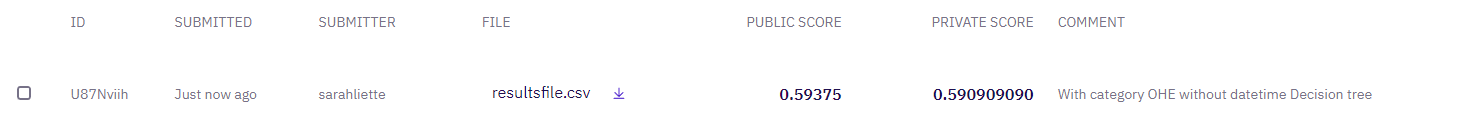
This one is worst with category than without

## 2. With OHE and without TransactionStartTime column or date columns

In [ ]:
# data cleaning
#Data loading
def_feature = pd.read_csv("input/Xente_Variable_Definitions.csv")
raw_data = pd.read_csv("input/training.csv")
X_test = pd.read_csv("input/test.csv")
sample_submission = pd.read_csv("input/sample_submission.csv")

#attribut initialization
cols_unique_value = [] #Will be droped
for col in raw_data.columns : 
    if len(raw_data[col].unique()) == 1 :
        cols_unique_value.append(col)
        
medium_cardianlity_cols = ["ProductId"]

#Data transformation
raw_data['TransactionStartTime'] = pd.to_datetime(raw_data['TransactionStartTime'])
X_test['TransactionStartTime'] = pd.to_datetime(X_test['TransactionStartTime'])

#Data cleaning
data = raw_data.copy()
data = data.dropna(axis=0) #Drop observations/rows with missing values
X_test=X_test.dropna(axis=0)
data.drop(cols_unique_value, axis=1, inplace=True)
X_test.drop(cols_unique_value, axis=1, inplace=True)

#Prepare index for the submission
index_val = list(X_test.TransactionId.values.tolist())

#Set the df index to the Transction Id
data = transactioId_to_index(data)
X_test = transactioId_to_index(X_test)

#Adding data
#data = adding_date_col(data, 'TransactionStartTime')
#X_test = adding_date_col(X_test, 'TransactionStartTime')


# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in data.columns if data[cname].nunique() < 15 and 
                        data[cname].dtype == "object"]
low_cardinality_cols.append('PricingStrategy')

#transform columns BatchId_54 to number

l_col_str = ["BatchId", "AccountId", "SubscriptionId", "CustomerId", "ProviderId", "ProductId", "ChannelId"]
for col in l_col_str:
    data[['dc', 'new_col']] = data[col].str.split("_", expand = True)
    data.drop(['dc',col], inplace=True, axis=1)
    data.rename(columns={"new_col": col}, inplace=True)
    data[col] = data[col].astype('int')
    X_test[['dc', 'new_col']] = X_test[col].str.split("_", expand = True)
    X_test.drop(['dc',col], inplace=True, axis=1)
    X_test.rename(columns={"new_col": col}, inplace=True)
    X_test[col] = X_test[col].astype('int')
data['PricingStrategy'] = data['PricingStrategy'].astype('int')
X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('int')
data['Value'] = data['Value'].astype('float')
X_test['Value'] = X_test['Value'].astype('float')

X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('str')
data['PricingStrategy'] = data['PricingStrategy'].astype('str')

#Data splitting
y = data.FraudResult #The target label
X = data.copy()
X.drop(['FraudResult'], axis=1, inplace=True) #Only the features data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

#Other data
#Information on columns on raw_data
## P-e transformer ca en une fonction ? 
info = pd.DataFrame(data = raw_data.dtypes)
info.reset_index(inplace=True)
info.rename({'index':'Column Name', 0: 'Dtype'}, axis=1, inplace=True)
describe = def_feature.copy()
describe = describe.merge(info)
unique_val = []
for col in list(describe["Column Name"]) : 
    unique_val.append(len(raw_data[col].unique()))
describe["unique"]=unique_val
describe = added_column(describe)
cat_cols = [col for col in train_X.columns if train_X[col].dtype == "object"]#liste of obejct columns
cat_cols.append("PricingStrategy")#pcq mm si c'est un chiffre il faut le considérer comme une catégorie

#print(describe)


#low_cardinality_cols=["ProviderId", "ProductCategory", "ChannelId", "PricingStrategy"] 
#train_X[low_cardinality_cols] = train_X[low_cardinality_cols].astype(str) 
#val_X[low_cardinality_cols] = val_X[low_cardinality_cols].astype(str) 

OH_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X[low_cardinality_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[low_cardinality_cols]))
# One-hot encoding removed index; put it back
OH_cols_train.index = train_X.index
OH_cols_valid.index = val_X.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
#print(f'Col avant : {train_X.columns}')
num_X_train = train_X.drop(low_cardinality_cols, axis=1)
num_X_valid = val_X.drop(low_cardinality_cols, axis=1)
num_X_test = X_test.drop(low_cardinality_cols, axis=1)
#print(f'col num : {num_X_train.columns}')

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
#print(f'col apres concat : {OH_X_train.columns}')
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

# Problème de string
OH_X_train.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_valid.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_test.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)
OH_X_test.columns = OH_X_test.columns.astype(str)

train_X = OH_X_train
val_X = OH_X_valid